# Bow-Tie link community walkthrough
Authored by Jorge S. Martinez Armas.

This notebook walks through the LinkNodeCommunity pipeline on a family of directed "bow-tie" graphs. Each graph contains two dense wings joined by a connector node whose incoming and outgoing arcs rotate across 12 variants. The example highlights how link directionality shapes the overlapping node communities (NOCs) recovered by the algorithm.

We proceed in four stages:
1. import the required Python wrappers and plotting helpers,
2. generate the bow-tie adjacency matrices,
3. fit LinkNodeCommunity on each variant and extract the induced node covers, and
4. visualise how the connector node's orientation alters the community assignments.

Short explanations accompany every cell so that a reader with no prior exposure to LinkNodeCommunity can reproduce the workflow end to end.


In [1]:
# Standard Python libs ----
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
import sys

# Add the parent directory to sys.path so src can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import LinkNodeCommunity as linknode
from src.LinkNodeCommunity.utils import cut_tree_with_validation, collapsed_partition
from src.viz.graphics import graph_network_covers


## Step 1 · Construct the bow-tie family

The helper `make_bowties` returns 12 adjacency matrices that share the same two densely connected wings. Parameter `ww` controls the weaker cross-cluster links, and `ws` the stronger intra-cluster arcs. Node `A` plays the role of the connector: we cyclically permute its six directed links so that each variant emphasises a different arrangement of in- and out-links.

Run the function below to materialise the matrices that will feed the LinkNodeCommunity models.


In [2]:
def make_bowties():
  ww = 1
  ws = 5

  bowtie = np.array(
    [
      [0, -1, -1, -1, -1, -1, -1],
      [-1, 0, ws, ws, 0, 0, 0],
      [-1, 0, 0, ws, 0, 0, 0],
      [-1 ,ws ,0, 0, 0, 0 ,0],
      [-1, 0, 0, 0, 0, ws, ws],
      [-1, 0, 0, 0, ws, 0, 0],
      [-1, 0, 0, 0, ws, ws, 0]
    ]
  )
  A = np.array(
    [
      ww, ww, ww,
      ws, ws, ws,
      0, 0, 0,
      0, 0, 0
    ]
  )
  n = 12
  x = np.arange(n)
  Graphs = []
  rows, cols = np.where(bowtie == -1)
  for i in np.arange(n):
    wheel = np.zeros(n)
    wheel[i:] = x[:(n-i)]
    wheel[:i] = x[(n-i):]
    wheel = wheel.astype(int)
    bowtie_copy = bowtie.copy()
    bowtie_copy[rows, cols] = A[wheel]
    Graphs.append(
     bowtie_copy
    )
  return n, Graphs


## Step 2 · Instantiate the clustering models

For every matrix we build a directed NetworkX graph, label the seven nodes `A` through `G`, and fit `linknode.Clustering`. Setting `flat_mode=True` allows the similarity computation to return 0.0 when the feature vector of either node in the similarity score calculation is flat (i.e., contains only zeros).

The loop collects `(graph, model)` pairs so the analysis code can iterate over ready-to-plot objects.


In [3]:
n, Graphs = make_bowties()
original_labels = np.array(["A", "B", "C", "D", "E", "F", "G"])

# Prepare label mappings so plots display A–G instead of node indices
labels_dict = dict()
for i in np.arange(7):
  labels_dict[i] = original_labels[i]
toy_labels = {i: original_labels[i] for i in np.arange(len(original_labels))}

# Fit LinkNodeCommunity on each bow-tie variant and store the results

clustering = []
for i, g in enumerate(Graphs):
  g = nx.from_numpy_array(g, create_using=nx.DiGraph)
  model = linknode.Clustering(g, similarity_index="cosine_similarity", consider_subgraph=False)
  model.add_labels(toy_labels)
  model.fit(flat_mode=True, method="matrix")
  clustering.append([g, model])

> **Note**  
> The console message `Adding remaining node communities due to topological constraints.` appears when the refinement step merges leftover singletons so that every link community induces a connected node cover. It is expected for small synthetic examples and simply means the end-step criterion from the manuscript kicked in; no extra action is required.


## Step 3 · Inspect the first six variants

To interpret the hierarchy we select the level that maximises the density score `D` via `linknode_equivalence_partition`. We then derive the node partition, feed it to `NOCFinder` to compute overlapping memberships, and rescale edge weights to improve layout readability before plotting.

The panels below show the first six bow-tie variants. Each subplot displays two primary link communities (colours) and highlights how node `A` is assigned depending on the orientation of its links.


/Users/jmrtnza/Documents/Documents - Jorge’s MacBook Air/Work/Research/LINKPROJECT/LinkNodeCommunity/.venv/lib/python3.12/site-packages/networkx/drawing/layout.py:982: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)
/Users/jmrtnza/Documents/Documents - Jorge’s MacBook Air/Work/Research/LINKPROJECT/LinkNodeCommunity/.venv/lib/python3.12/site-packages/networkx/drawing/layout.py:1008: RuntimeWarning: invalid value encountered in subtract
  grad = np.einsum("ij,ij,ijk->ik", invdist, offset, direction) - np.einsum(


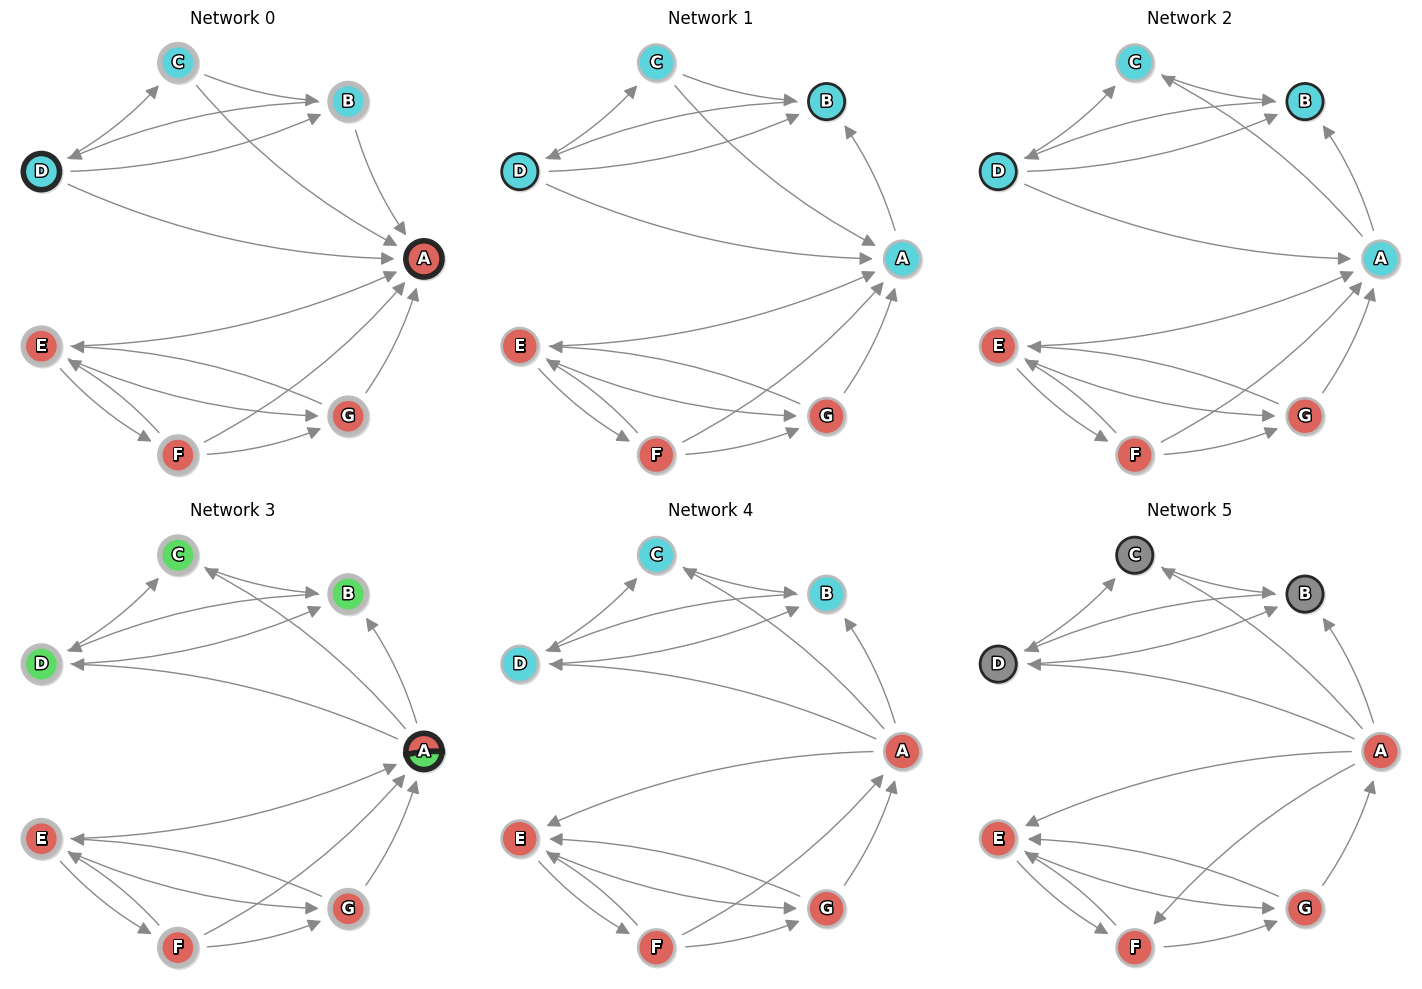

In [4]:
# Density-driven level selection (D score)
score = "D"

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx in range(6):
    number_link_communities, \
        number_node_communities, \
            height_at_maximum = clustering[idx][1].equivalence_partition(score=score)

    node_partition = cut_tree_with_validation(clustering[idx][1].Z, number_node_communities)
    node_partition = collapsed_partition(node_partition)  # Collapse to consecutive integers starting from 0

    # All graphs share the same node labels (A–G)
    node_labels = np.array([clustering[0][1].G.nodes[n]["label"] \
                            for n in sorted(clustering[0][1].G.nodes())]
                                )

    # Compute NOCs using the node partition
    nocs_model = linknode.NOCFinder(
        clustering[idx][0], node_partition,
        undirected=False,
        labels=node_labels,
        similarity_index="cosine_similarity",
        tie_policy="include_equal"
    )

    # Fit the NOC model using the precomputed link similarity matrices
    nocs_model.fit(
        clustering[idx][1].linksim.source_sim_matrix,
        clustering[idx][1].linksim.target_sim_matrix
    )

    # Create a copy of the graph with transformed edge weights
    Gdist = clustering[idx][0].copy()
    weights = [d['weight'] for u, v, d in Gdist.edges(data=True)]
    max_weight = max(weights) if weights else 1
    for u, v, d in Gdist.edges(data=True):
        d['weight'] = 1 - d['weight'] / max_weight

    pos = nx.kamada_kawai_layout(Gdist)

    # Plot on the corresponding axis
    graph_network_covers(
        clustering[idx][0],
        pos,
        nocs_model.node_cover_partition,
        node_partition,
        nocs_model.single_node_cover_map,
        nocs_model.single_nodes_cover_scores,
        node_labels,
        figsize=(5, 5),
        scale=0.5,
        ax=axes[idx]
    )
    axes[idx].set_title(f"Network {idx}")

plt.tight_layout()
plt.show()


## Step 4 · Compare the remaining variants

We repeat the same routine for the last six graphs in the sequence. Because the orientation of node `A` keeps shifting, these cases capture the full cycle of configurations—from predominantly incoming edges to predominantly outgoing edges.

Use the figure to track when node `A` falls into a single community, overlaps both, or becomes isolated as inter-cluster connectivity fades.


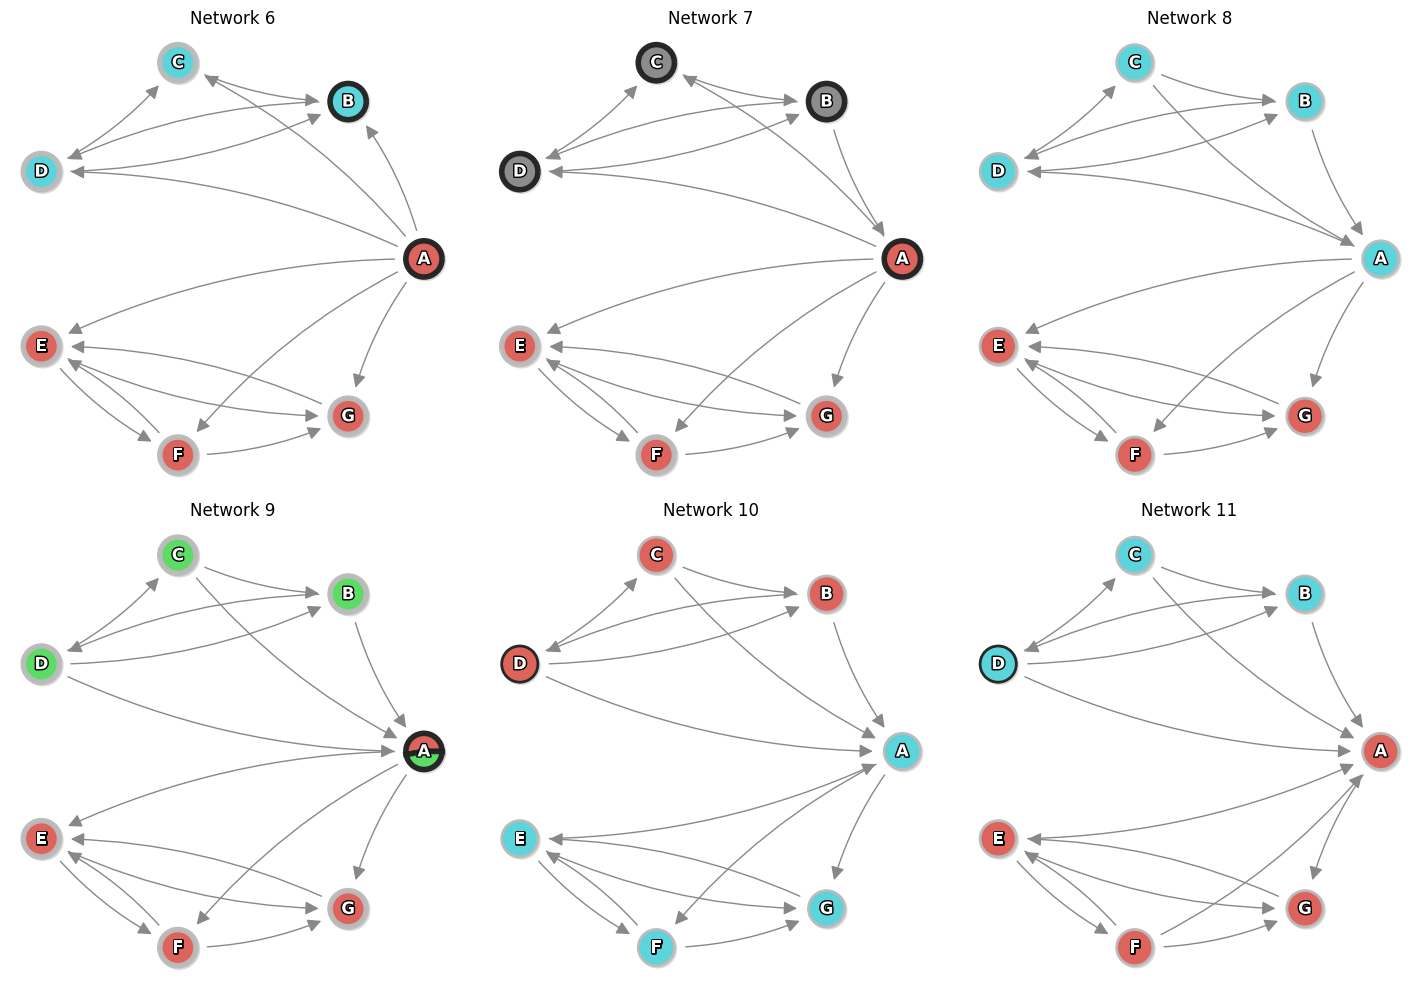

In [5]:
# Reuse the density score to complete the cycle of variants
score = "D"

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx in range(6, 12):
    number_link_communities, \
        number_node_communities, \
            height_at_maximum = clustering[idx][1].equivalence_partition(score=score)

    node_partition = cut_tree_with_validation(clustering[idx][1].Z, number_node_communities)
    node_partition = collapsed_partition(node_partition)  # Collapse to consecutive integers starting from 0

    # All graphs share the same node labels (A–G)
    node_labels = np.array([clustering[0][1].G.nodes[n]["label"] \
                            for n in sorted(clustering[0][1].G.nodes())]
                                )

    # Compute NOCs using the node partition
    nocs_model = linknode.NOCFinder(
        clustering[idx][0], node_partition,
        undirected=False,
        labels=node_labels,
        similarity_index="cosine_similarity",
        tie_policy="include_equal"
    )

    # Fit the NOC model using the precomputed link similarity matrices
    nocs_model.fit(
        clustering[idx][1].linksim.source_sim_matrix,
        clustering[idx][1].linksim.target_sim_matrix
    )

    # Create a copy of the graph with transformed edge weights
    Gdist = clustering[idx][0].copy()
    weights = [d['weight'] for u, v, d in Gdist.edges(data=True)]
    max_weight = max(weights) if weights else 1
    for u, v, d in Gdist.edges(data=True):
        d['weight'] = 1 - d['weight'] / max_weight

    pos = nx.kamada_kawai_layout(Gdist)

    # Plot on the corresponding axis
    graph_network_covers(
        clustering[idx][0],
        pos,
        nocs_model.node_cover_partition,
        node_partition,
        nocs_model.single_node_cover_map,
        nocs_model.single_nodes_cover_scores,
        node_labels,
        figsize=(5, 5),
        scale=0.5,
        ax=axes[idx-6]
    )
    axes[idx-6].set_title(f"Network {idx}")

plt.tight_layout()
plt.show()


## Observations

- When node `A` distributes links symmetrically between both wings, the `D` optimum assigns it to both node covers, signalling overlapping membership created by balanced traffic.
- As the edges tilt towards one wing, `D` prioritises the denser side and `A` is absorbed into that single community. The opposite wing remains cohesive but loses `A` because its contribution to density drops.
- In the final configurations, where `A` only exports edges or only receives them, the hierarchy collapses into a single community. Without a bidirectional bridge the wings behave as a single component under the density criterion.

Pedagogical takeaway: the LinkNodeCommunity pipeline responds strongly to the directionality of the hub node. Inspecting the `D` optimum alongside the plotted covers reveals whether an overlapping connector genuinely spans two communities or merely funnels traffic one way. Note that link directionality can suppress overlaps even when the undirected skeleton still resembles a bow-tie.
